## 3. Linear Regression

Using CPI as an indicator of an inflationary environment, we used linear regression analysis to evaluate the suitability of each factor in predicting the likelihood of inflation. As our datasets all contain time-series data, we believe that it is appropriate to begin with linear regression to evaluate the factors we have identified.

In [755]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sb
from datetime import datetime

# Import linear regression libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

In [757]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

### Predicting CPI using US Unemployment Rate

In [760]:
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data.rename(columns={'DATE': 'Date'}, inplace=True)
cpi_data.rename(columns={'CPIAUCSL': 'Value'}, inplace=True)
cpi_data_clean = df_dates_monthly(cpi_data)

In [762]:
# Clean CPI data to have same time period as Unemployment Rate data
cpi_data_clean = cpi_data_clean[(cpi_data_clean.Date>='1948-01') & (cpi_data_clean.Date<='2021-11')]

In [764]:
cpi_data_clean.shape

(887, 2)

In [766]:
unemp_data = pd.read_csv("data/unemployment_rate_data.csv")

# Clean unemployment data to have date in %Y-%m format
unemp_data.rename({"date": "Date","unrate": "Rate"},axis=1,inplace=True)
unemp_data = df_dates_monthly(unemp_data)

# Clean unemployment data to keep columns Date and unemployment rate
unemp_data_clean = pd.DataFrame(unemp_data[['Date','Rate']])

In [768]:
unemp_data_clean.shape

(887, 2)

In [770]:
# Create new dateframes for reference
unemp = pd.DataFrame(unemp_data_clean[['Rate']])
cpi = pd.DataFrame(cpi_data_clean[['Value']])

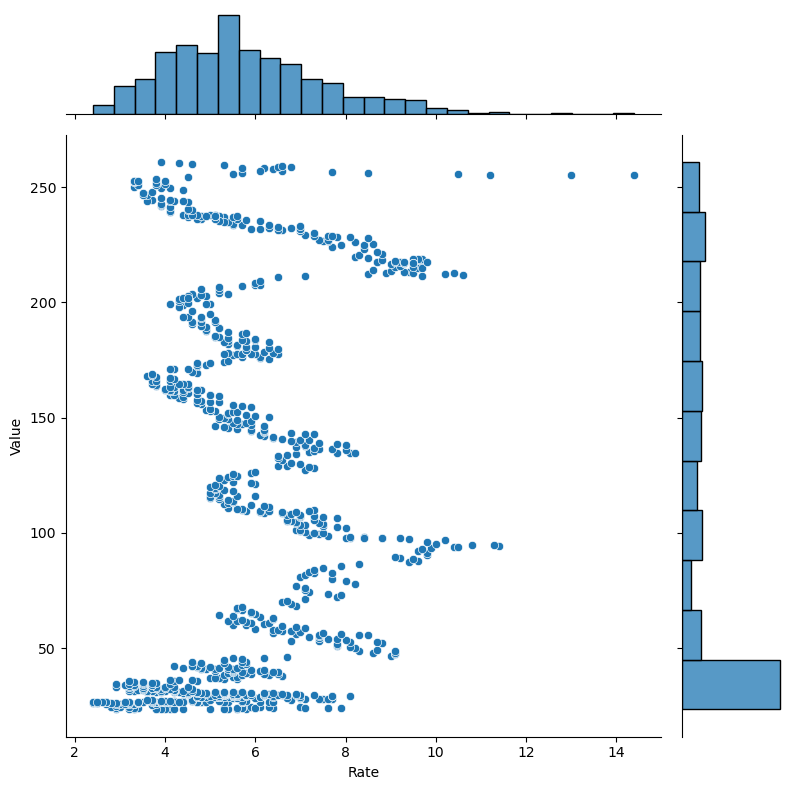

In [772]:
# Visualise relationship between CPI and Unemployment rate data
cpi_unemp_data = pd.concat([unemp,cpi], axis=1).reindex(unemp.index)
sb.jointplot(data=cpi_unemp_data, x='Rate', y='Value', height = 8)

#### Preparing train and test datasets
> Total data points: 887 values  
> Train set: 710 values (80% of total size)  
> Test set: 177 values (20% of total size)

In [775]:
# Preparation of train and test datasets
unemp_train, unemp_test, cpi_train, cpi_test = train_test_split(unemp,cpi,test_size=177)

In [777]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(unemp_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(unemp_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': Lasso(alpha=0.1), 'regressor__alpha': 0.1}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', Lasso(alpha=0.1))])
Test Set MSE: 5949.347600779977


In [779]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [781]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', Lasso(alpha=0.1))])
Lasso(alpha=0.1)
[-36.05679779]
[ 0.         59.17872416 -7.65635934  0.35570204]


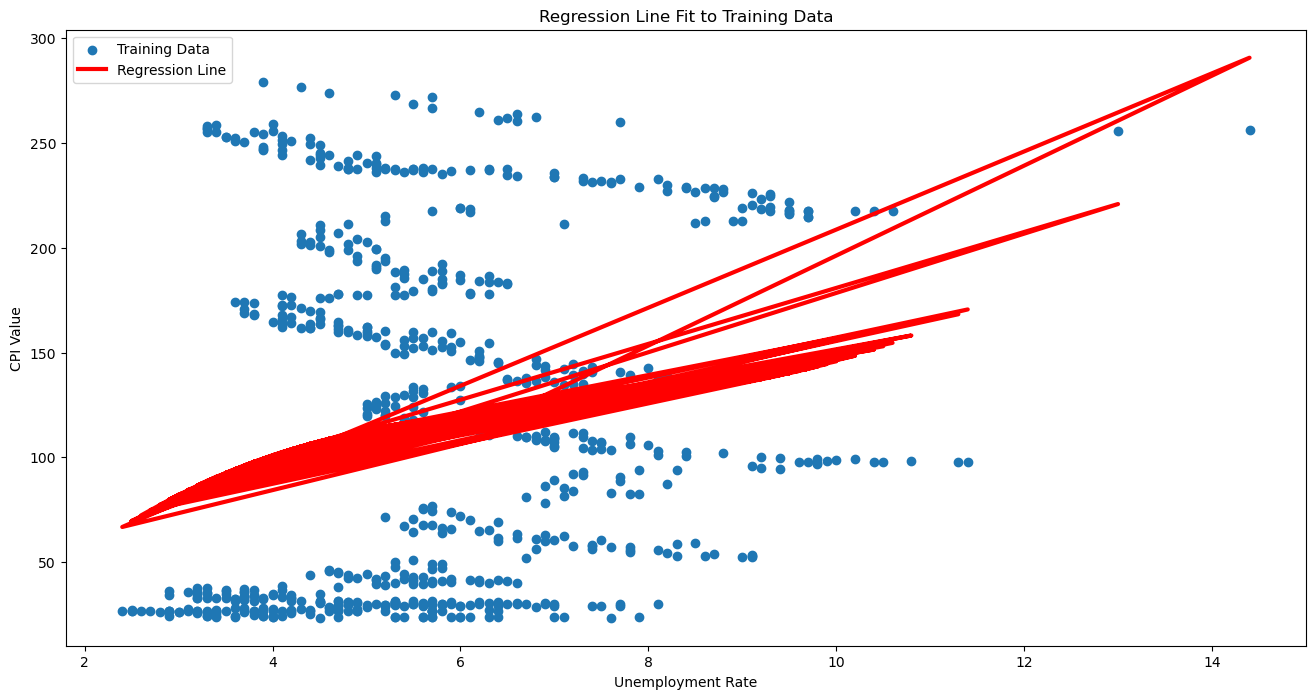

In [783]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform unemp_train using PolynomialFeatures
unemp_train_transformed = poly_transformer.transform(unemp_train)

# Compute regression line using the transformed features
regline_y = regressor.intercept_ + np.dot(unemp_train_transformed, regressor.coef_)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(unemp_train, cpi_train, label="Training Data")
plt.plot(unemp_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("Unemployment Rate")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [785]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_unemp = round(best_model.score(unemp_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_unemp)

Explained Variance (R^2) for the best model: 0.05


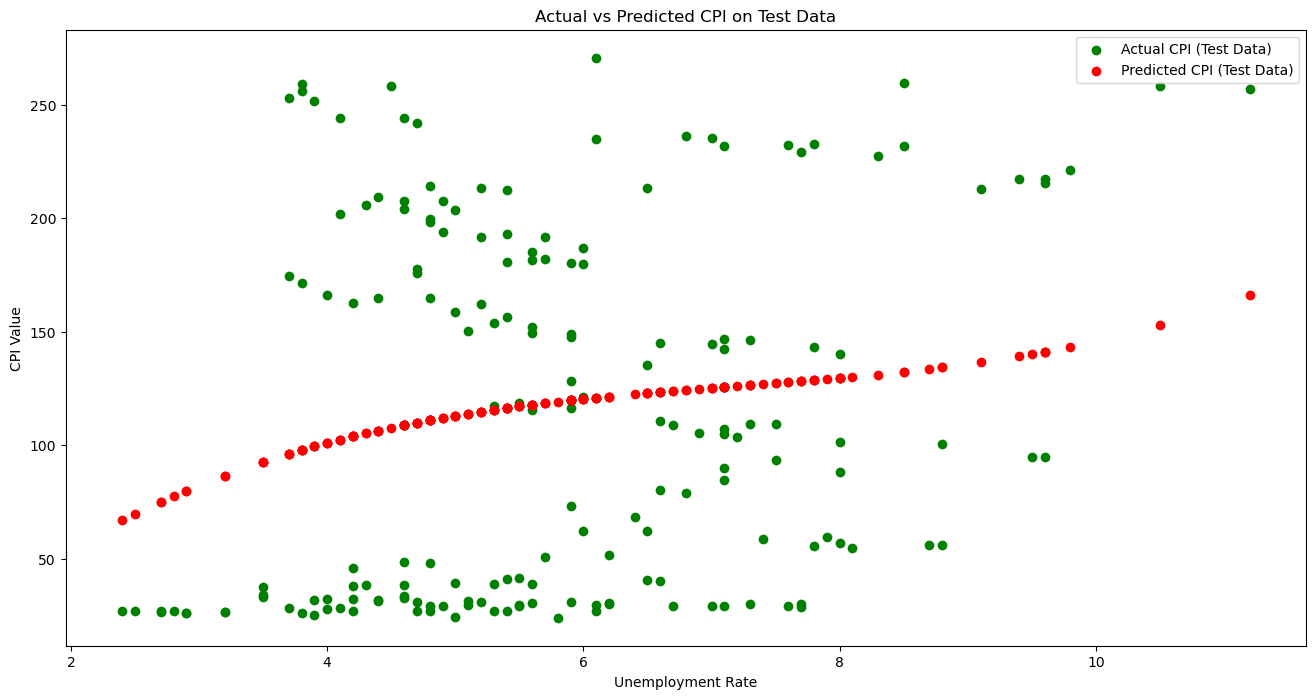

In [787]:
import matplotlib.pyplot as plt

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(unemp_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(unemp_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(unemp_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("Unemployment Rate")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [789]:
# Root Mean Squared Error (RMSE) for comparison
rmse_unemp = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)

In [791]:
rmse_unemp

77.13

### Predicting CPI using S&P 500 data

In [794]:
sp_data = pd.read_csv("data/sp_monthly.csv")

# Clean S&P data to have date in %Y-%m format
# sp_data['Date'] = pd.to_datetime(sp_data['Date'], format='%b %y')
sp_data = df_dates_monthly(sp_data)

# Clean S&P data to keep only Date and Change % columns, sorted in ascending order of date
sp_data_clean = pd.DataFrame(sp_data[['Date','Open']])
sp_data_clean.columns = ['Date', 'Price']
sp_data_clean.sort_values(by=['Date'], inplace=True)

# Clean S&P data to have same time period as CPI data
sp_data_clean = sp_data_clean[(sp_data_clean.Date<='2024-07')]
sp_data_clean.set_index('Date', inplace=True)

In [796]:
# Clean CPI data to have date in %Y-%m format
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data.rename(columns={'DATE': 'Date'}, inplace=True)
cpi_data.rename(columns={'CPIAUCSL': 'Value'}, inplace=True)
cpi_data_clean = df_dates_monthly(cpi_data)

# Clean CPI data to have same time period as SP data
cpi_data_clean = cpi_data_clean[(cpi_data_clean.Date>='1985-01')]
cpi_data_clean.set_index('Date', inplace=True)

In [798]:
cpi_data_clean.head()

,Value
Date,
1985-01,105.7
1985-02,106.3
1985-03,106.8
1985-04,107.0
1985-05,107.2


In [800]:
sp_data_clean.head()

,Price
Date,
1985-01,167.199997
1985-02,179.630005
1985-03,181.179993
1985-04,180.660004
1985-05,179.830002


In [802]:
sp_data_clean.shape

(475, 1)

In [804]:
cpi_data_clean.shape

(475, 1)

In [806]:
# Create new dataframes for reference
sp = pd.DataFrame(sp_data_clean[['Price']])
cpi = pd.DataFrame(cpi_data_clean[['Value']])

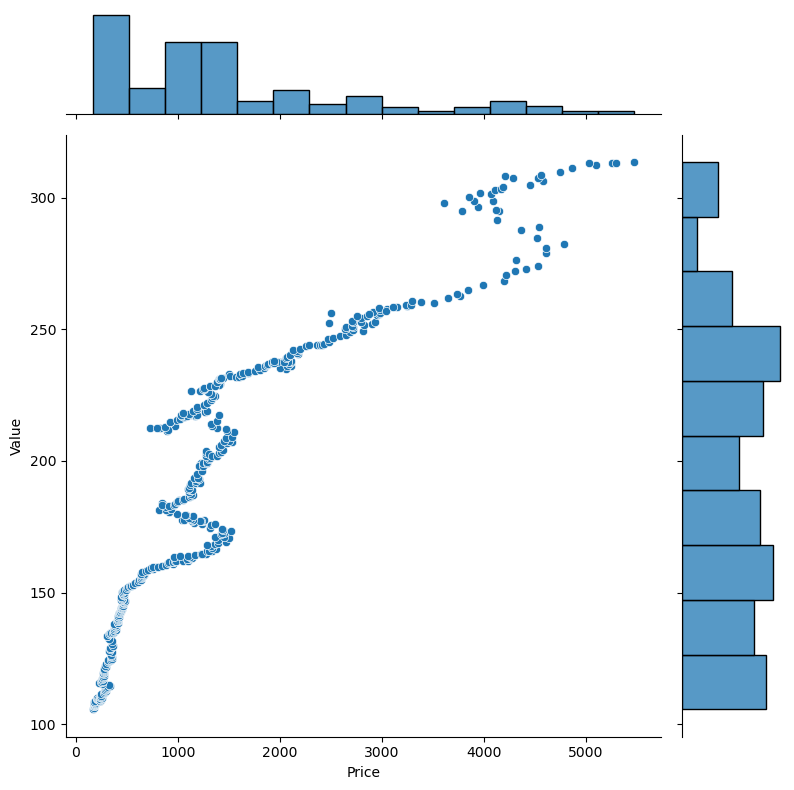

In [808]:
# Visualise relationship between CPI and Unemployment rate data
cpi_sp_data = pd.concat([sp,cpi], axis=1).reindex(sp.index)

sb.jointplot(data=cpi_sp_data, x='Price', y='Value', height = 8)

#### Preparing train and test sets
> Total size: 475 values  
> Train set: 380 values  
> Test set: 95 values

In [823]:
# Preparation of train and test datasets
sp_train, sp_test, cpi_train, cpi_test = train_test_split(sp,cpi,test_size=95)

In [825]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(sp_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(sp_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': Ridge(alpha=10.0), 'regressor__alpha': 10.0}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', Ridge(alpha=10.0))])
Test Set MSE: 245.2851033800891


In [827]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [829]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', Ridge(alpha=10.0))])
Ridge(alpha=10.0)
[92.61938861]
[[ 0.00000000e+00  1.16135201e-01 -2.80017747e-05  2.69138583e-09]]


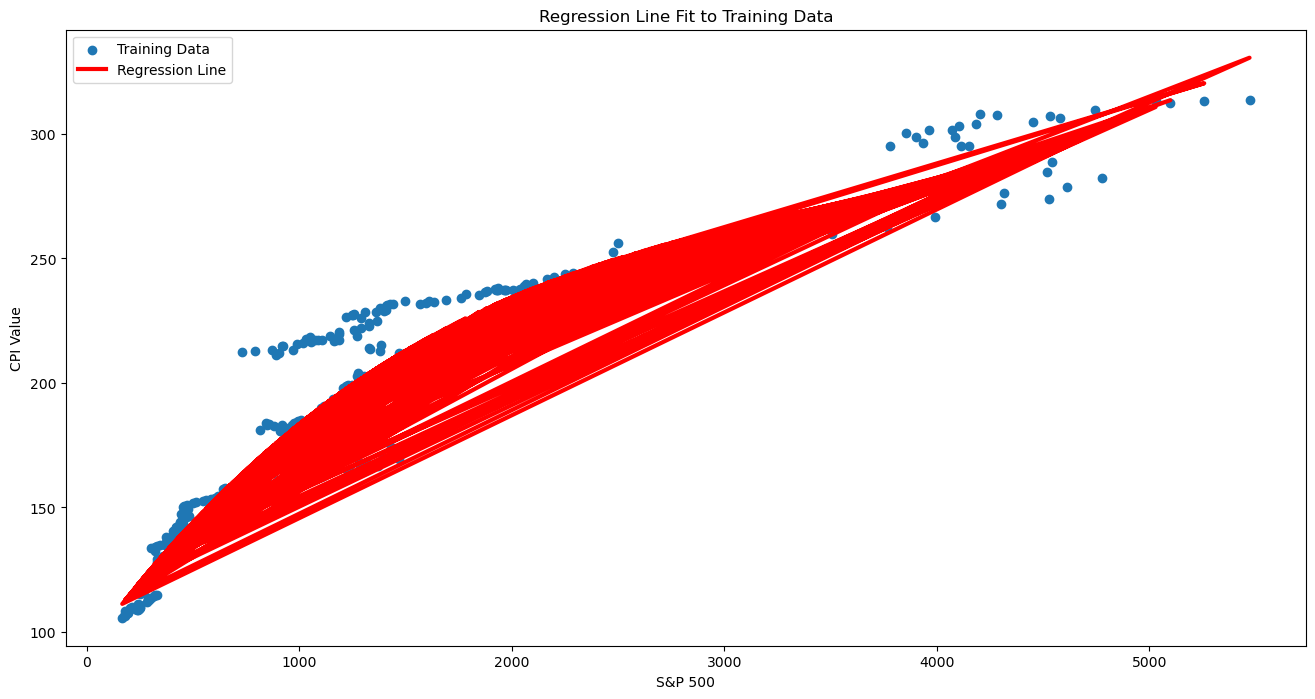

In [833]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform unemp_train using PolynomialFeatures
sp_train_transformed = poly_transformer.transform(sp_train)

# Compute regression line using the transformed features
regline_y = regressor.intercept_ + np.dot(sp_train_transformed, regressor.coef_.ravel())

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(sp_train, cpi_train, label="Training Data")
plt.plot(sp_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("S&P 500")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [835]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_sp = round(best_model.score(sp_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_sp)

Explained Variance (R^2) for the best model: 0.92


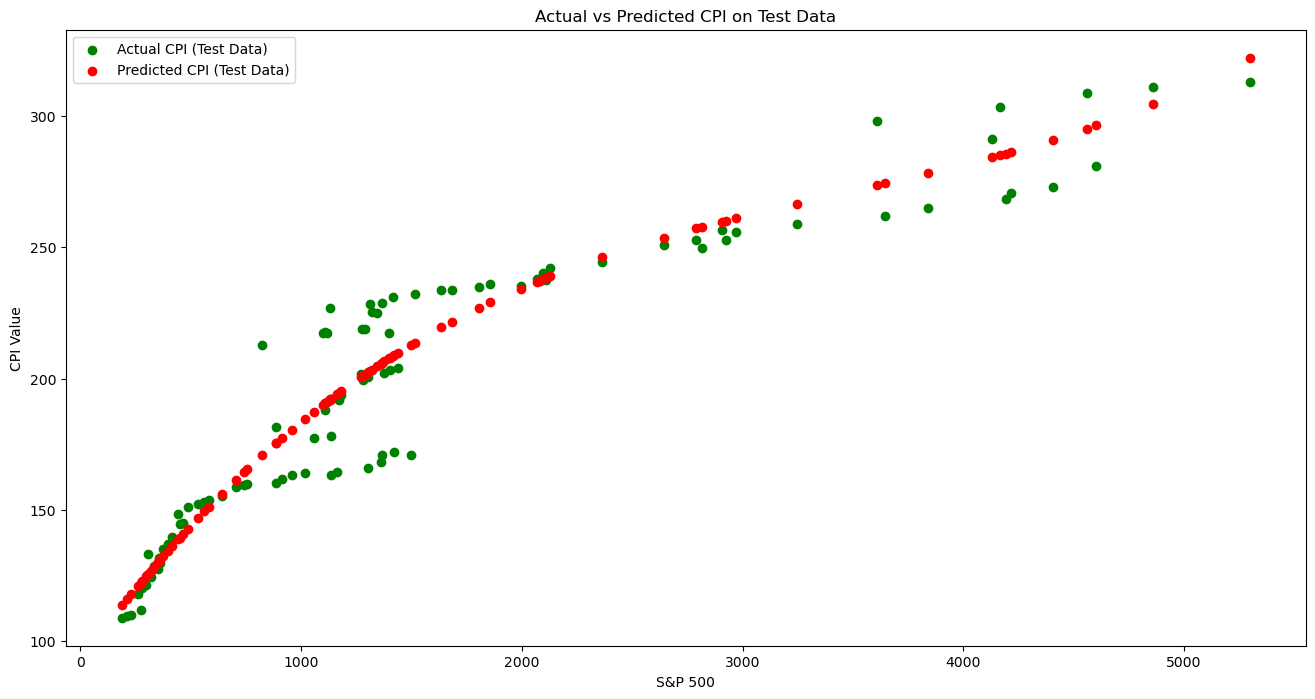

In [837]:
import matplotlib.pyplot as plt

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(sp_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(sp_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(sp_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("S&P 500")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [839]:
# Root Mean Squared Error (RMSE) for comparison
rmse_sp = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)

In [841]:
rmse_sp

15.66

### Predicting CPI using inflation expectations data

In [844]:
# Import BIE data and see the head
bie_data = pd.read_excel("data/bie_data.xlsx")
bie_data.columns = ['Date', 'mean','Value']
bie_data = bie_data.drop('mean',axis=1)
bie_data.head()

,Date,Value
0,2011-10-21,0.019269
1,2011-11-18,0.020115
2,2011-12-16,0.018592
3,2012-01-20,0.018283
4,2012-02-17,0.018718


In [846]:
# Since this data looks ahead 1 year at inflation, we need to bring the dates forward by 1 year as well
bie_data['Date'] = bie_data['Date'] + pd.DateOffset(months=12)

In [848]:
# Clean BIE data by rounding Value
bie_data['AvgUnitCostChange'] = round(bie_data['Value'],6)
bie_data = bie_data.drop('Value',axis=1)
# Clean data to have date in %Y-%m format
bie_clean = df_dates_monthly(bie_data)
bie_clean = bie_clean[(bie_clean.Date<='2024-07')]
bie_clean.set_index('Date', inplace=True)
# Show cleaned data
bie_clean

,AvgUnitCostChange
Date,
2012-10,0.019269
2012-11,0.020115
2012-12,0.018592
2013-01,0.018283
2013-02,0.018718
...,...
2024-03,0.031294
2024-04,0.028395
2024-05,0.029387


In [850]:
# Clean CPI data to have date in %Y-%m format
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data.rename(columns={'DATE': 'Date'}, inplace=True)
cpi_data.rename(columns={'CPIAUCSL': 'Value'}, inplace=True)
cpi_data_clean = df_dates_monthly(cpi_data)

# Clean CPI data to have same time period as SP data
cpi_data_clean = cpi_data_clean[(cpi_data_clean.Date>='2012-10')]
cpi_data_clean.set_index('Date', inplace=True)

In [852]:
cpi_data_clean

,Value
Date,
2012-10,231.638
2012-11,231.249
2012-12,231.221
2013-01,231.679
2013-02,232.937
...,...
2024-03,312.230
2024-04,313.207
2024-05,313.225


In [854]:
bie_clean.shape

(142, 1)

In [856]:
cpi_data_clean.shape

(142, 1)

In [858]:
# Create new dataframes for reference
bie = pd.DataFrame(bie_clean[['AvgUnitCostChange']])
bie = bie.reset_index(drop=True)
cpi = pd.DataFrame(cpi_data_clean[['Value']])
cpi = cpi.reset_index(drop=True)

In [860]:
bie.head()

,AvgUnitCostChange
0,0.019269
1,0.020115
2,0.018592
3,0.018283
4,0.018718


In [862]:
cpi.head()

,Value
0,231.638
1,231.249
2,231.221
3,231.679
4,232.937


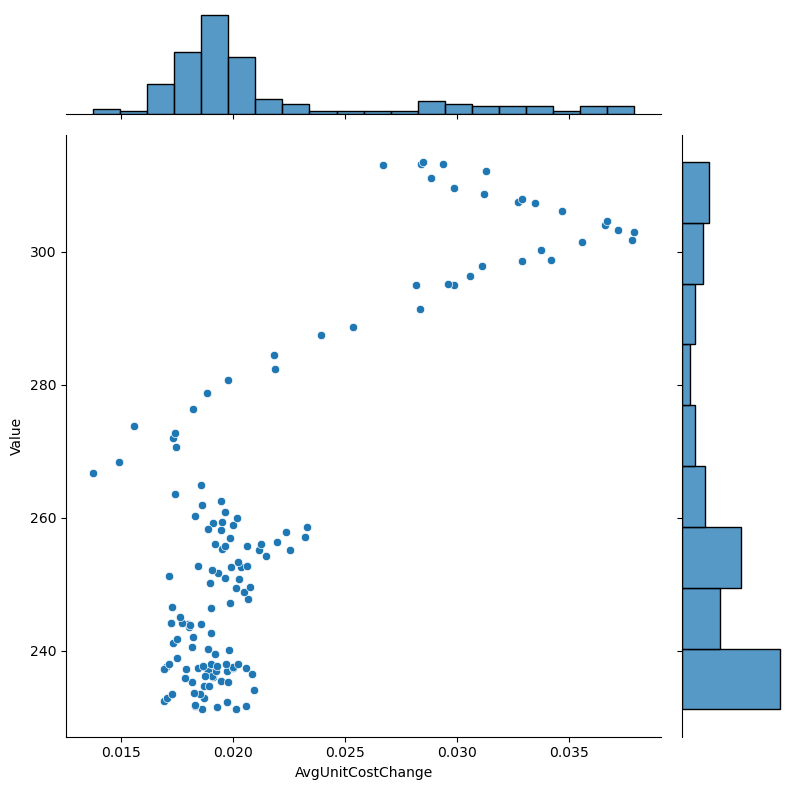

In [864]:
# Visualise relationship between CPI and Unemployment rate data
cpi_bie_data = pd.merge(bie,cpi,left_index=True,right_index=True)
sb.jointplot(data=cpi_bie_data, x='AvgUnitCostChange', y='Value', height = 8)

#### Preparing train and test datasets
> Total size: 142 values  
> Train set: 114 values  
> Test set: 28 values

In [867]:
# Preparation of train and test datasets
bie_train, bie_test, cpi_train, cpi_test = train_test_split(bie,cpi,test_size=28)

In [869]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(bie_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(bie_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': LinearRegression(), 'regressor__fit_intercept': True}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])
Test Set MSE: 122.57506517529224


In [871]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [873]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])
LinearRegression()
[672.18620735]
[[        0.            -59665.55178712   2615253.30664847
  -34468986.25445721]]


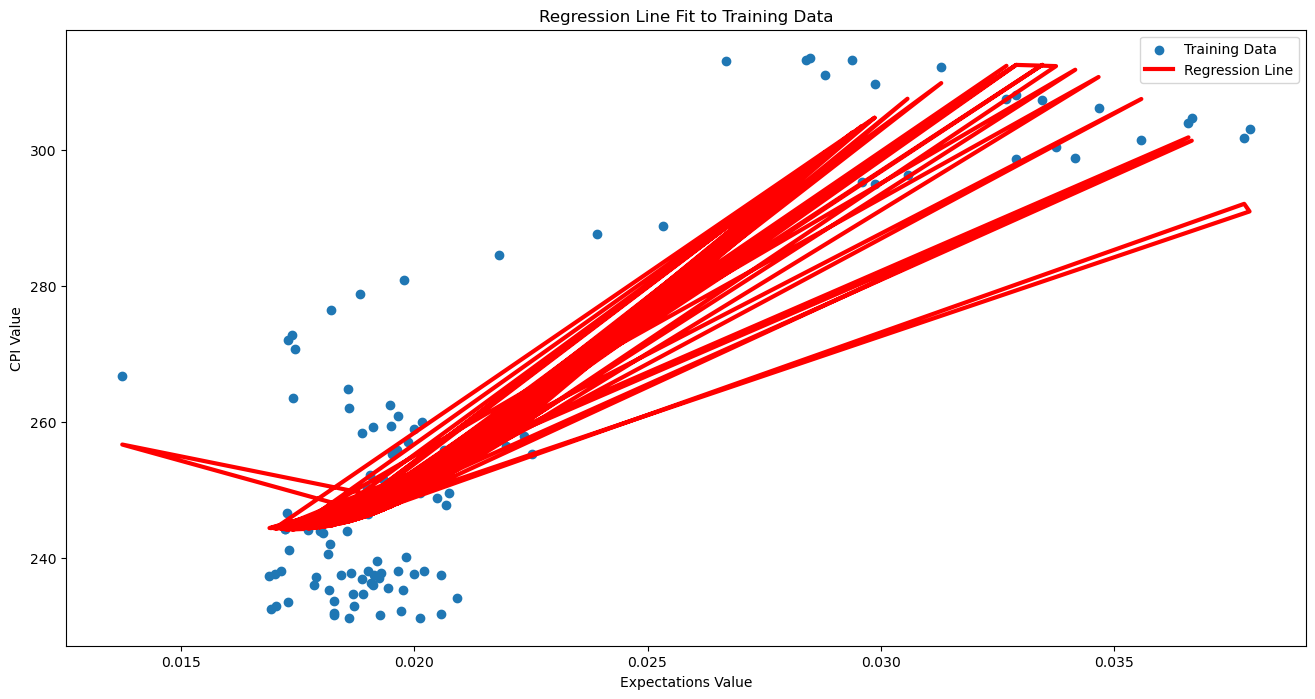

In [875]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform bie_train using PolynomialFeatures
bie_train_transformed = poly_transformer.transform(bie_train)

# Ensure coefficients are properly shaped for dot product
coefficients = regressor.coef_.ravel()  # Flatten if needed
regline_y = regressor.intercept_ + np.dot(bie_train_transformed, coefficients)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(bie_train, cpi_train, label="Training Data")
plt.plot(bie_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("Expectations Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [877]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_bie = round(best_model.score(bie_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_bie)

Explained Variance (R^2) for the best model: 0.79


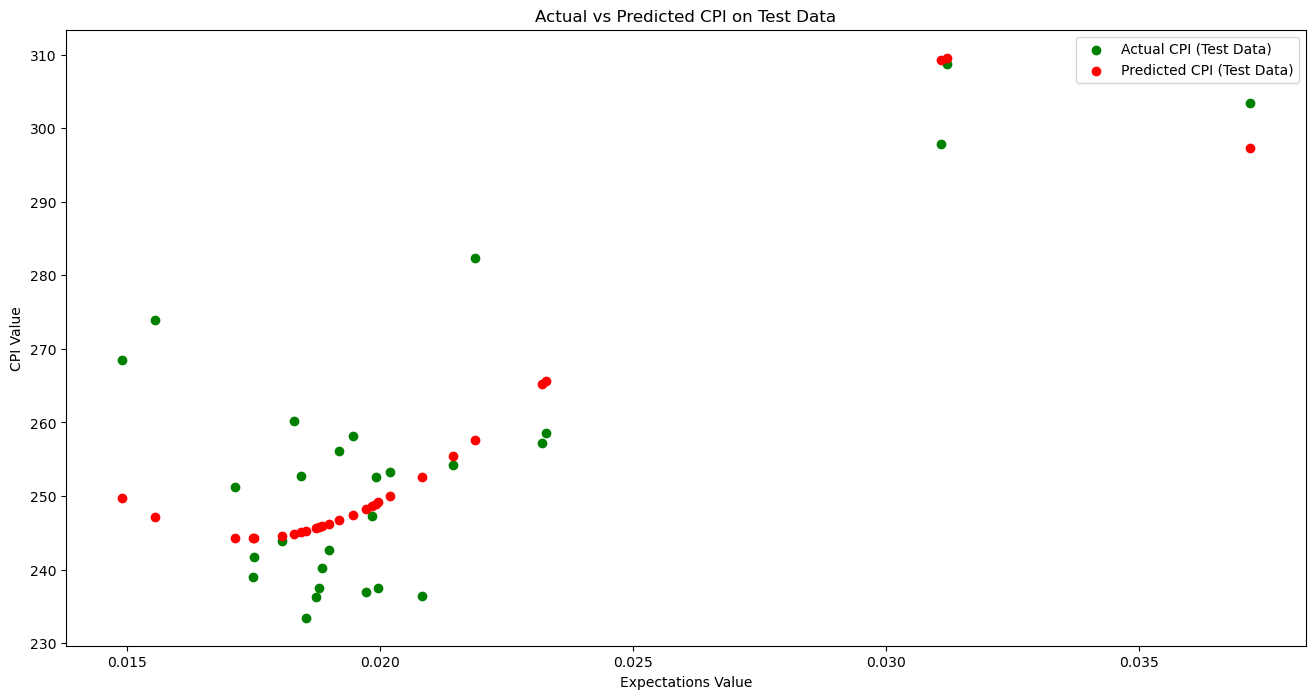

In [879]:
import matplotlib.pyplot as plt

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(bie_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(bie_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(bie_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("Expectations Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [881]:
# Root Mean Squared Error (RMSE) for comparison
rmse_bie = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)
rmse_bie

11.07

### Predicting CPI using oil price data

In [884]:
# Import oil price data and see the head
oil_data = pd.read_csv("data/cleaned/cleaned_oil.csv")
oil_data

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1986-01,22.93,NaN,NaN
1,1986-02,15.46,-0.325774,NaN
2,1986-03,12.61,-0.184347,NaN
3,1986-04,12.84,0.018239,NaN
4,1986-05,15.38,0.197819,NaN
...,...,...,...,...
459,2024-04,85.35,0.050074,0.074261
460,2024-05,80.02,-0.062449,0.117910
461,2024-06,79.77,-0.003124,0.135516
462,2024-07,81.80,0.025448,0.075325


In [886]:
oil_data['percentChange'] = round(oil_data['ChangePercentMonth'],6)
# Clean data to have monthly and yearly percentage changes
oil_data_clean = oil_data.drop(columns={'ChangePercentMonth','ChangePercentYear'}, axis=1)
oil_data_clean = oil_data_clean[(oil_data_clean.Date<='2024-07')]
oil_data_clean.set_index('Date',inplace=True)
oil_data_clean.dropna(inplace=True)
# Show cleaned data
oil_data_clean['price'] = oil_data_clean['Value']
oil_data_clean.drop(columns={'Value', 'percentChange'},inplace=True)
oil_data_clean

,price
Date,
1986-02,15.46
1986-03,12.61
1986-04,12.84
1986-05,15.38
1986-06,13.43
...,...
2024-03,81.28
2024-04,85.35
2024-05,80.02


In [888]:
# Clean CPI data to have date in %Y-%m format
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data.rename(columns={'DATE': 'Date'}, inplace=True)
cpi_data.rename(columns={'CPIAUCSL': 'Value'}, inplace=True)
cpi_data_clean = df_dates_monthly(cpi_data)

# Clean CPI data to have same time period as SP data
cpi_data_clean = cpi_data_clean[(cpi_data_clean.Date>='1986-02')]
cpi_data_clean.set_index('Date', inplace=True)

In [890]:
cpi_data_clean

,Value
Date,
1986-02,109.700
1986-03,109.100
1986-04,108.700
1986-05,109.000
1986-06,109.400
...,...
2024-03,312.230
2024-04,313.207
2024-05,313.225


In [892]:
# Create new dataframes for reference
oil = pd.DataFrame(oil_data_clean[['price']])
oil = oil.reset_index(drop=True)
cpi = pd.DataFrame(cpi_data_clean[['Value']])
cpi = cpi.reset_index(drop=True)

In [894]:
oil

,price
0,15.46
1,12.61
2,12.84
3,15.38
4,13.43
...,...
457,81.28
458,85.35
459,80.02
460,79.77


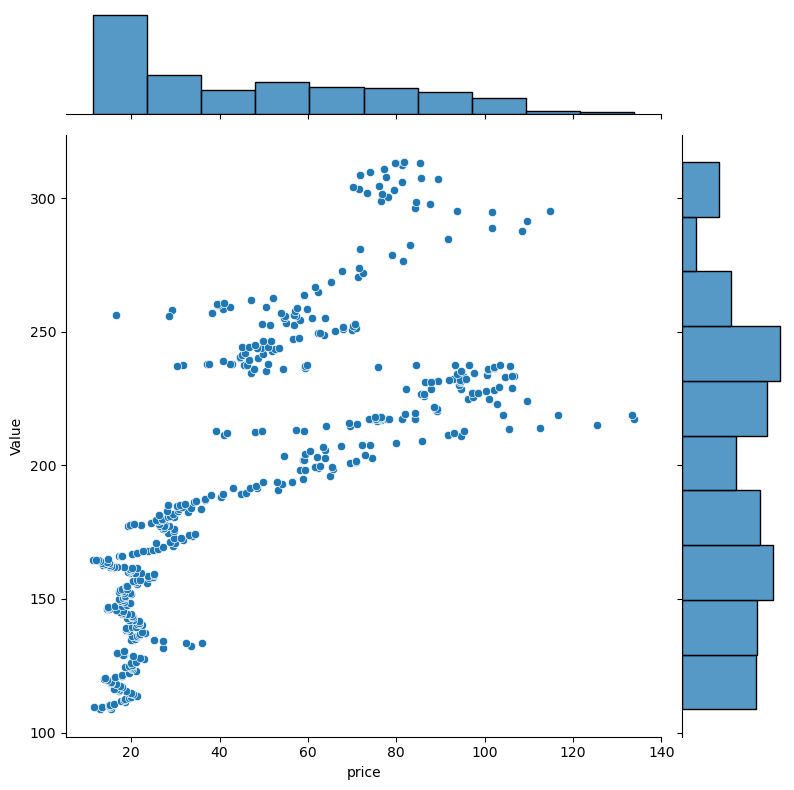

In [896]:
# Visualise relationship between CPI and Unemployment rate data
cpi_oil_data = pd.merge(oil,cpi,left_index=True,right_index=True)
sb.jointplot(data=cpi_oil_data, x='price', y='Value', height = 8)

In [898]:
oil.shape

(462, 1)

In [900]:
cpi.shape

(462, 1)

#### Preparing train and test datasets
> Total size: 462 values  
> Train set: 370 values  
> Test set: 92 values

In [903]:
# Preparation of train and test datasets
oil_train, oil_test, cpi_train, cpi_test = train_test_split(oil,cpi,test_size=92)

In [905]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(oil_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(oil_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': LinearRegression(), 'regressor__fit_intercept': True}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])
Test Set MSE: 832.7917407901454


In [907]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [909]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])
LinearRegression()
[63.05207007]
[[ 0.00000000e+00  5.20980152e+00 -4.45940929e-02  1.04011606e-04]]


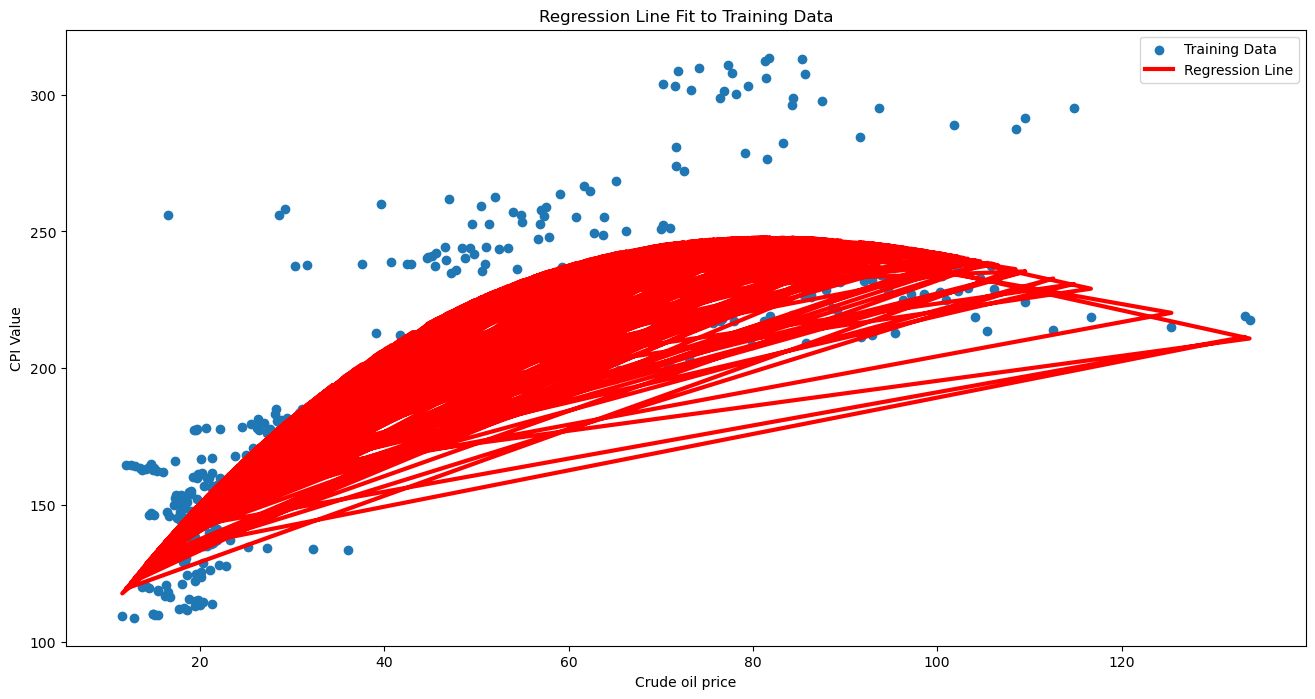

In [911]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform bie_train using PolynomialFeatures
oil_train_transformed = poly_transformer.transform(oil_train)

# Ensure coefficients are properly shaped for dot product
coefficients = regressor.coef_.ravel()  # Flatten if needed
regline_y = regressor.intercept_ + np.dot(oil_train_transformed, coefficients)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(oil_train, cpi_train, label="Training Data")
plt.plot(oil_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("Crude oil price")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [913]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_oil = round(best_model.score(oil_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_oil)

Explained Variance (R^2) for the best model: 0.72


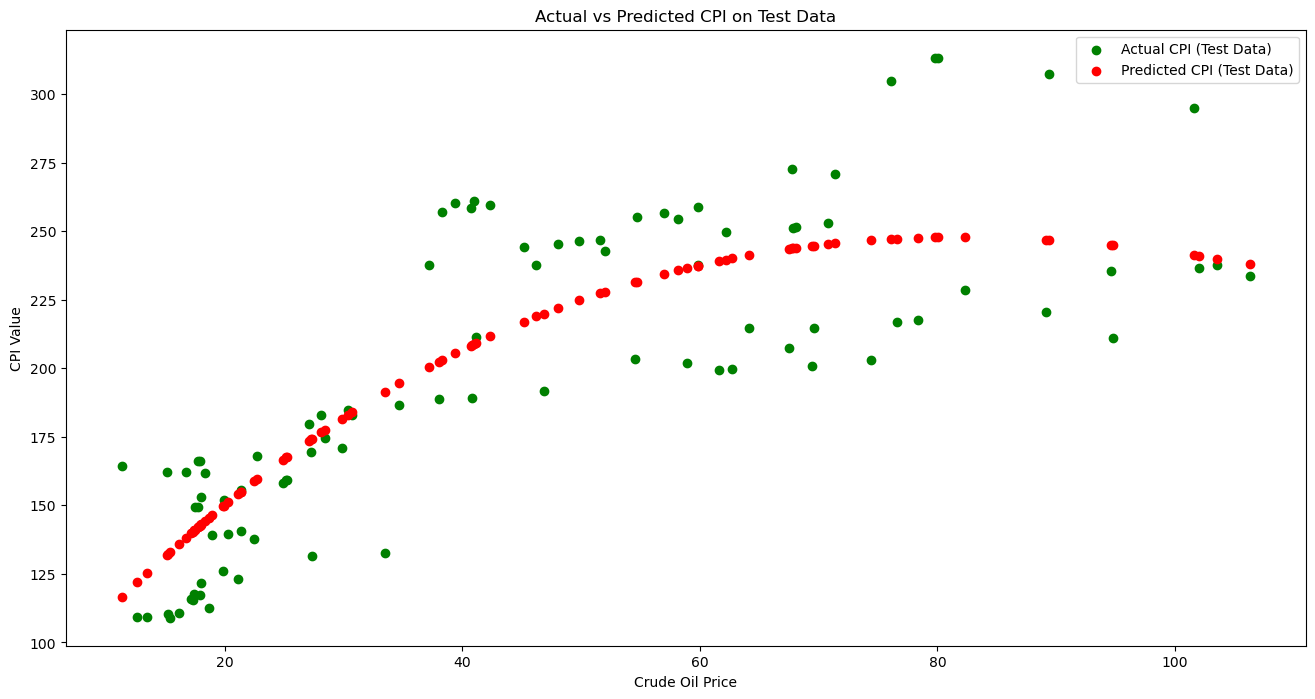

In [915]:
import matplotlib.pyplot as plt

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(oil_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(oil_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(oil_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("Crude Oil Price")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [917]:
# Root Mean Squared Error (RMSE) for comparison
rmse_oil = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)
rmse_oil

28.86

### Predicting CPI using Nominal Effective Exchange Rate (NEER) data

In [920]:
# Import cleaned PPI and CPI data
neer_data_clean = pd.read_csv('data/cleaned/cleaned_neer.csv')
cpi_data_clean = pd.read_csv('data/cleaned/cleaned_cpi.csv')

In [922]:
# Merge both datasets
neer_cpi = pd.merge(neer_data_clean, cpi_data_clean, how='inner',on='Date')
neer_cpi

,Date,Value_x,ChangePercentMonth_x,ChangePercentYear_x,Value_y,ChangePercentMonth_y,ChangePercentYear_y
0,1994-01,71.18,NaN,NaN,146.300,0.000000,0.024510
1,1994-02,71.26,0.001124,NaN,146.700,0.002734,0.025157
2,1994-03,71.76,0.007017,NaN,147.100,0.002727,0.026518
3,1994-04,72.39,0.008779,NaN,147.200,0.000680,0.023644
4,1994-05,72.36,-0.000414,NaN,147.500,0.002038,0.022885
...,...,...,...,...,...,...,...
362,2024-03,104.26,-0.002392,0.009684,312.230,0.003781,0.034751
363,2024-04,105.39,0.010838,0.031516,313.207,0.003129,0.033577
364,2024-05,105.21,-0.001708,0.024440,313.225,0.000057,0.032502
365,2024-06,106.76,0.014732,0.036002,313.049,-0.000562,0.029756


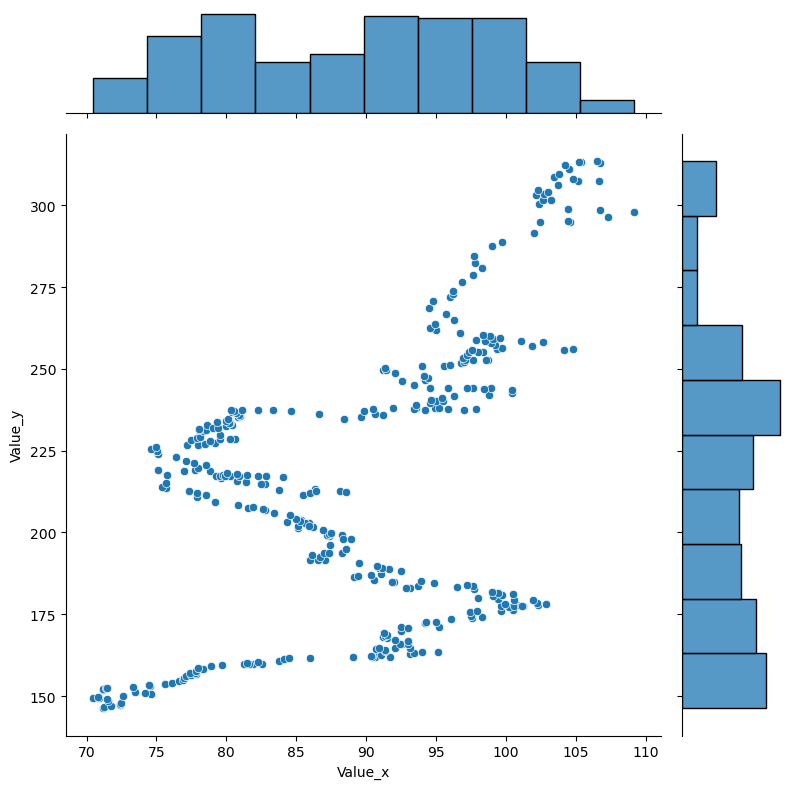

In [924]:
# Visualise the relationship between NEER and CPI data
sb.jointplot(data=neer_cpi, x='Value_x', y='Value_y', height = 8)

#### Preparing train and test datasets
> Total size: 367 values

> Train set: 294 values

> Test set: 73 values

In [927]:
# Preparation of train and test datasets
neer_train, neer_test, cpi_train, cpi_test = train_test_split(neer_cpi[['Value_x']],neer_cpi[['Value_y']],test_size=73)

In [929]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(neer_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(neer_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': LinearRegression(fit_intercept=False), 'regressor__fit_intercept': False}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
Test Set MSE: 1093.5456740263135


In [931]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [933]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
LinearRegression(fit_intercept=False)
0.0
[[-9.85126100e+03  3.49214902e+02 -4.03398073e+00  1.55030563e-02]]


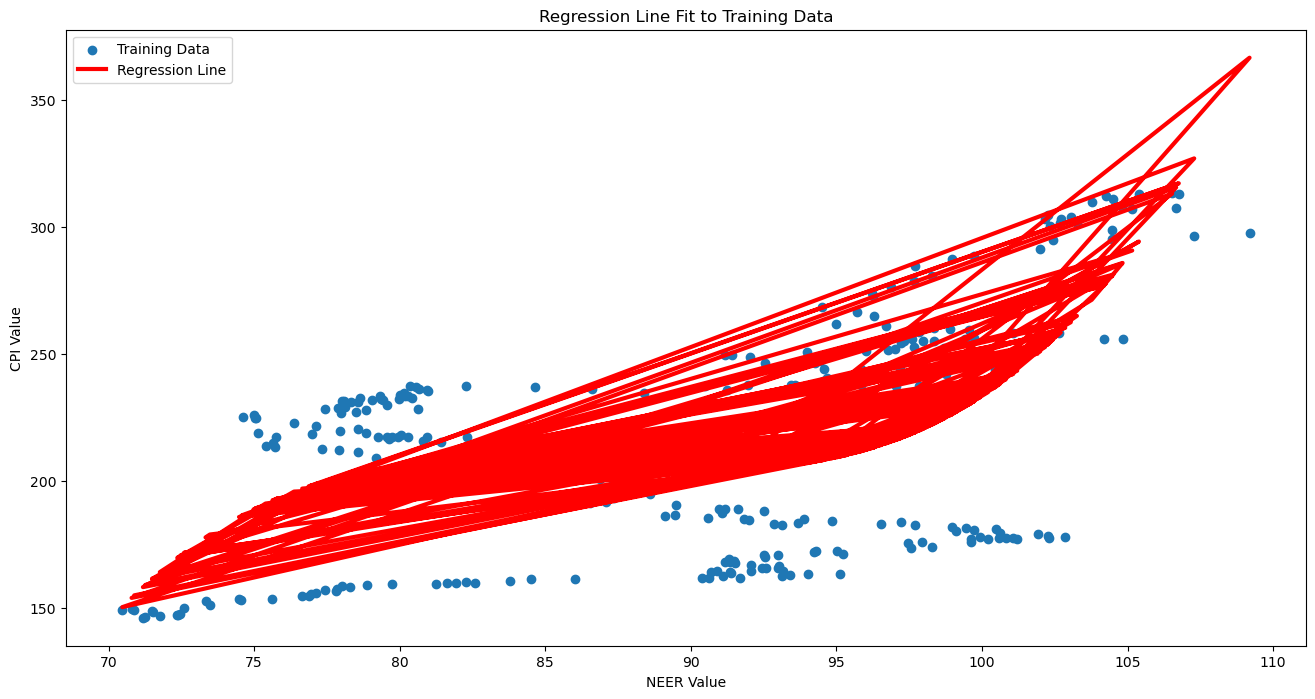

In [935]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform neer_train using PolynomialFeatures
neer_train_transformed = poly_transformer.transform(neer_train)

# Ensure coefficients are properly shaped for dot product
coefficients = regressor.coef_.ravel()  # Flatten if needed
regline_y = regressor.intercept_ + np.dot(neer_train_transformed, coefficients)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(neer_train, cpi_train, label="Training Data")
plt.plot(neer_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("NEER Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [937]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_neer = round(best_model.score(neer_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_neer)

Explained Variance (R^2) for the best model: 0.37


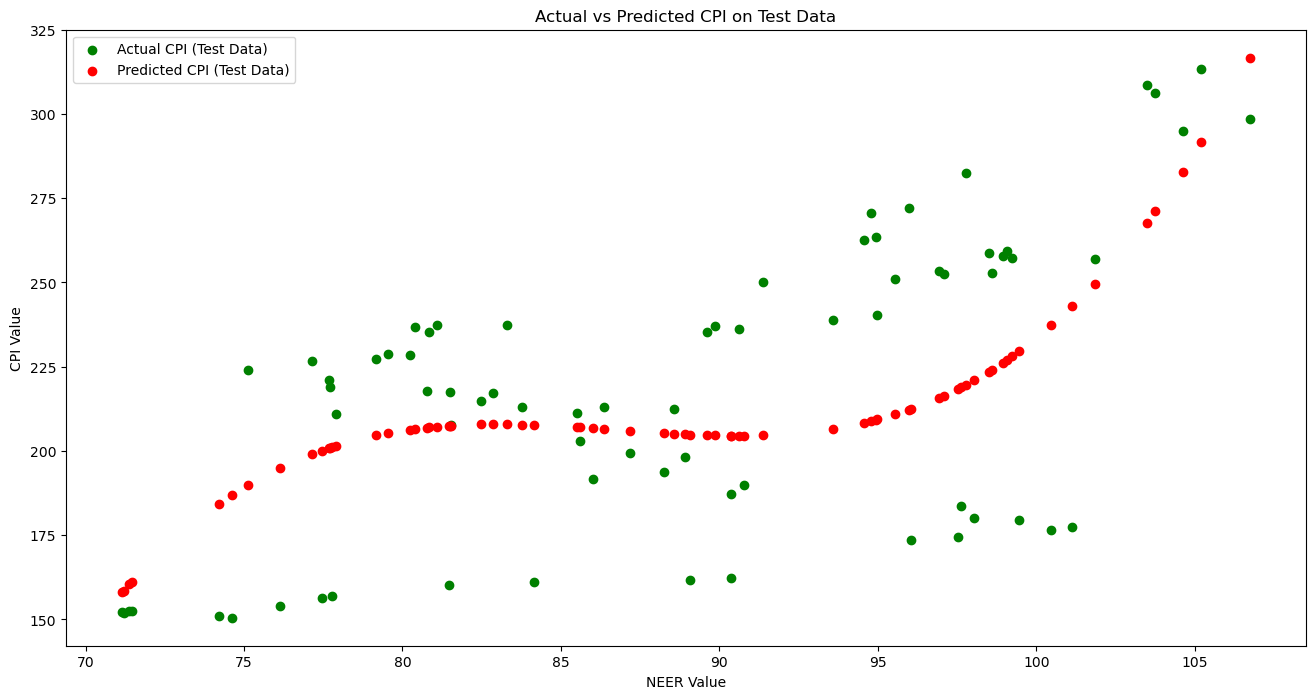

In [939]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(neer_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(neer_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(neer_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("NEER Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [941]:
# Root Mean Squared Error (RMSE) for comparison
rmse_neer = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)
rmse_neer

33.07

### Predicting CPI using Producer Price Index (PPI) data

In [944]:
# Import cleaned PPI and CPI data
ppi_data_clean = pd.read_csv('data/cleaned/cleaned_ppi.csv')
cpi_data_clean = pd.read_csv('data/cleaned/cleaned_cpi.csv')

In [946]:
# Merge both datasets
ppi_cpi = pd.merge(ppi_data_clean, cpi_data_clean, how='inner',on='Date')
ppi_cpi.dropna(inplace=True)
ppi_cpi

,Date,Value_x,ChangePercentMonth_x,ChangePercentYear_x,Value_y,ChangePercentMonth_y,ChangePercentYear_y
12,1948-01,27.700,0.018382,0.130612,23.680,0.011534,0.102421
13,1948-02,27.200,-0.018051,0.101215,23.670,-0.000422,0.094820
14,1948-03,27.200,0.000000,0.075099,23.500,-0.007182,0.068182
15,1948-04,27.400,0.007353,0.091633,23.820,0.013617,0.082727
16,1948-05,27.500,0.003650,0.100000,24.010,0.007976,0.093850
...,...,...,...,...,...,...,...
926,2024-03,255.095,0.000663,-0.007652,312.230,0.003781,0.034751
927,2024-04,256.984,0.007405,0.000296,313.207,0.003129,0.033577
928,2024-05,255.268,-0.006677,0.006300,313.225,0.000057,0.032502
929,2024-06,255.779,0.002002,0.007559,313.049,-0.000562,0.029756


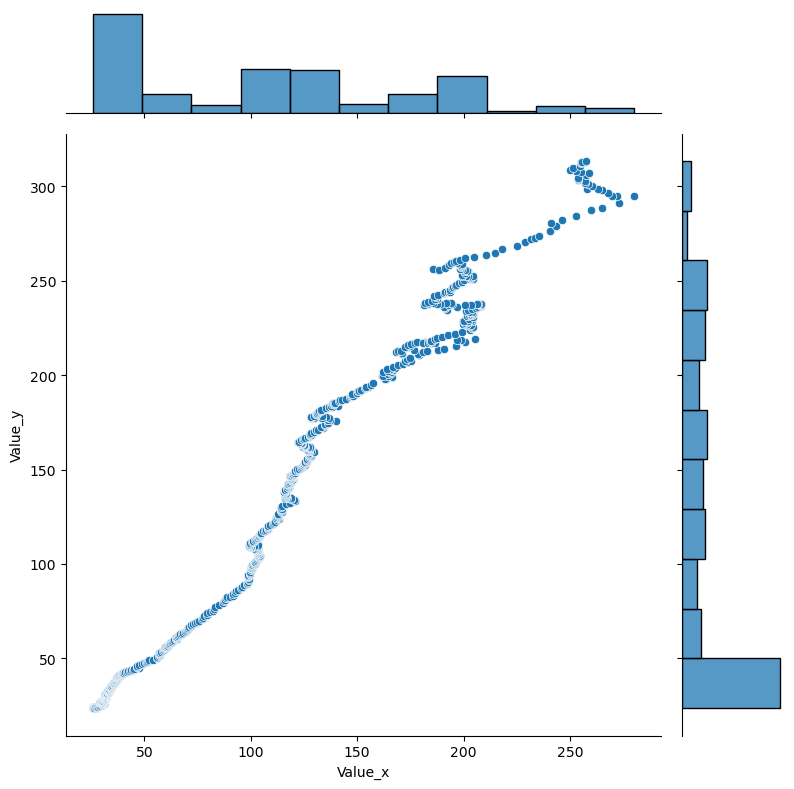

In [948]:
# Visualise the relationship between CPI and PPI data
sb.jointplot(data=ppi_cpi, x='Value_x', y='Value_y', height = 8)

#### Preparing train and test datasets
> Total size: 931 values  
> Train set: 745 values  
> Test set: 186 values

In [951]:
# Preparation of train and test datasets
ppi_train, ppi_test, cpi_train, cpi_test = train_test_split(ppi_cpi[['Value_x']],ppi_cpi[['Value_y']],test_size=186)

In [953]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(ppi_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(ppi_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': LinearRegression(fit_intercept=False), 'regressor__fit_intercept': False}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
Test Set MSE: 99.5265210853554


In [955]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [957]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
LinearRegression(fit_intercept=False)
0.0
[[ 4.79038187e+00  5.63372665e-01  7.04637919e-03 -1.89904499e-05]]


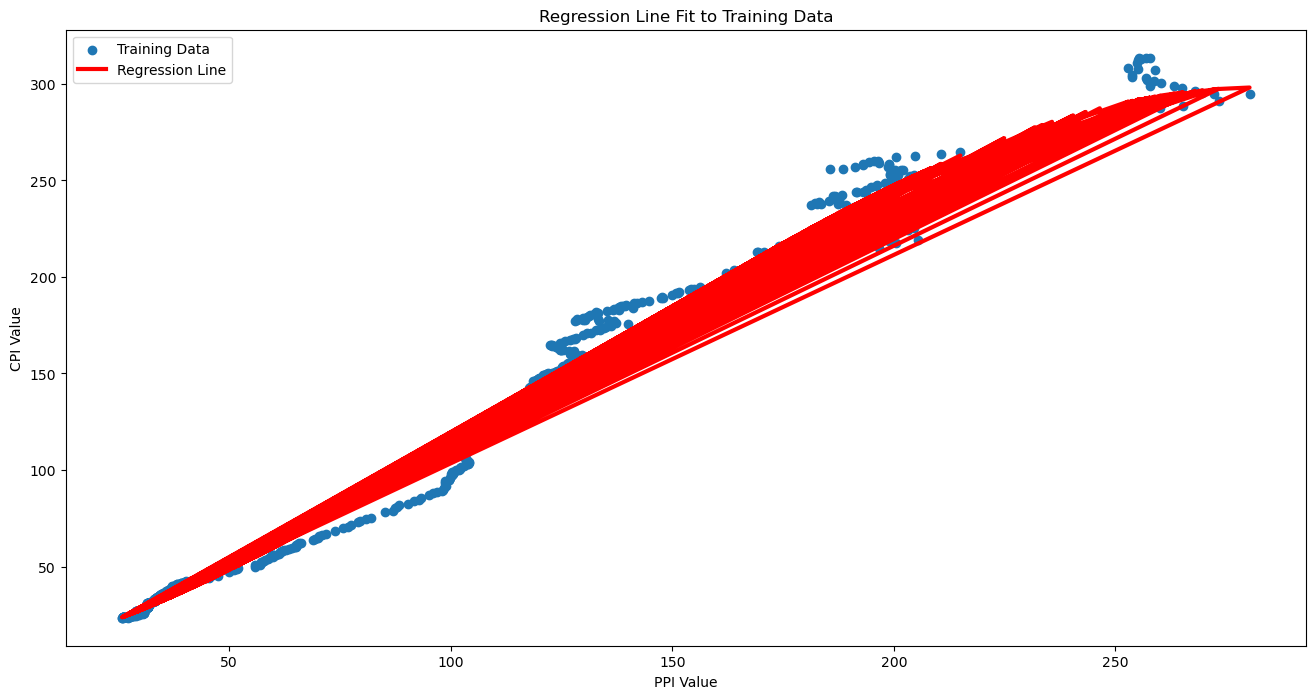

In [959]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform neer_train using PolynomialFeatures
ppi_train_transformed = poly_transformer.transform(ppi_train)

# Ensure coefficients are properly shaped for dot product
coefficients = regressor.coef_.ravel()  # Flatten if needed
regline_y = regressor.intercept_ + np.dot(ppi_train_transformed, coefficients)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(ppi_train, cpi_train, label="Training Data")
plt.plot(ppi_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("PPI Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [961]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_ppi = round(best_model.score(ppi_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_ppi)

Explained Variance (R^2) for the best model: 0.99


In [963]:
ppi_test.shape

(186, 1)

In [965]:
cpi_test.shape

(186, 1)

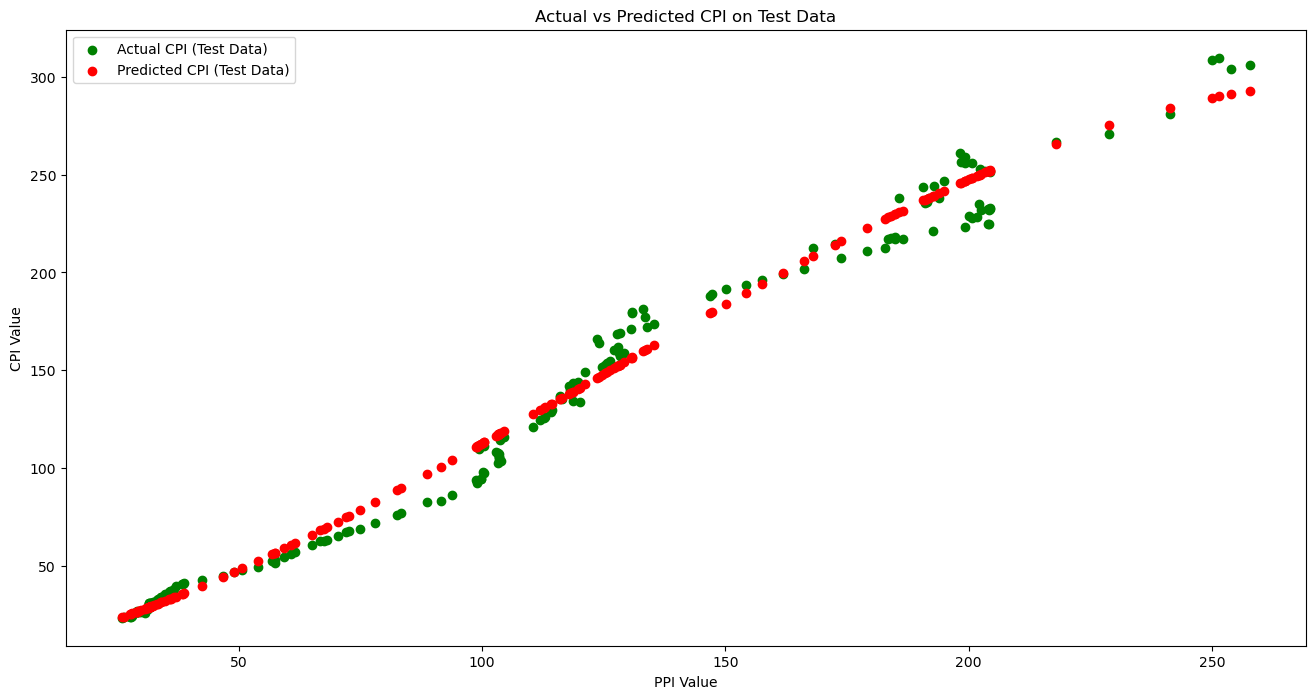

In [967]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(ppi_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(ppi_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(ppi_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("PPI Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [969]:
# Root Mean Squared Error (RMSE) for comparison
rmse_ppi = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)
rmse_ppi

9.98

### Predicting CPI using lagged CPI data

In [972]:
# Import cleaned CPI data twice
cpi_lagged_data_clean = pd.read_csv('data/cleaned/cleaned_lagged_cpi.csv')
cpi_data_clean = pd.read_csv('data/cleaned/cleaned_cpi.csv')

In [974]:
# Merge both datasets
lagged_cpi_cpi = pd.merge(cpi_lagged_data_clean, cpi_data_clean, how='inner',on='Date')
lagged_cpi_cpi

,Date,Value_x,ChangePercentMonth_x,ChangePercentYear_x,Value_y,ChangePercentMonth_y,ChangePercentYear_y
0,1947-02,21.480,NaN,NaN,21.620,0.006518,NaN
1,1947-03,21.620,0.006518,NaN,22.000,0.017576,NaN
2,1947-04,22.000,0.017576,NaN,22.000,0.000000,NaN
3,1947-05,22.000,0.000000,NaN,21.950,-0.002273,NaN
4,1947-06,21.950,-0.002273,NaN,22.080,0.005923,NaN
...,...,...,...,...,...,...,...
925,2024-03,311.054,0.004421,0.031657,312.230,0.003781,0.034751
926,2024-04,312.230,0.003781,0.034751,313.207,0.003129,0.033577
927,2024-05,313.207,0.003129,0.033577,313.225,0.000057,0.032502
928,2024-06,313.225,0.000057,0.032502,313.049,-0.000562,0.029756


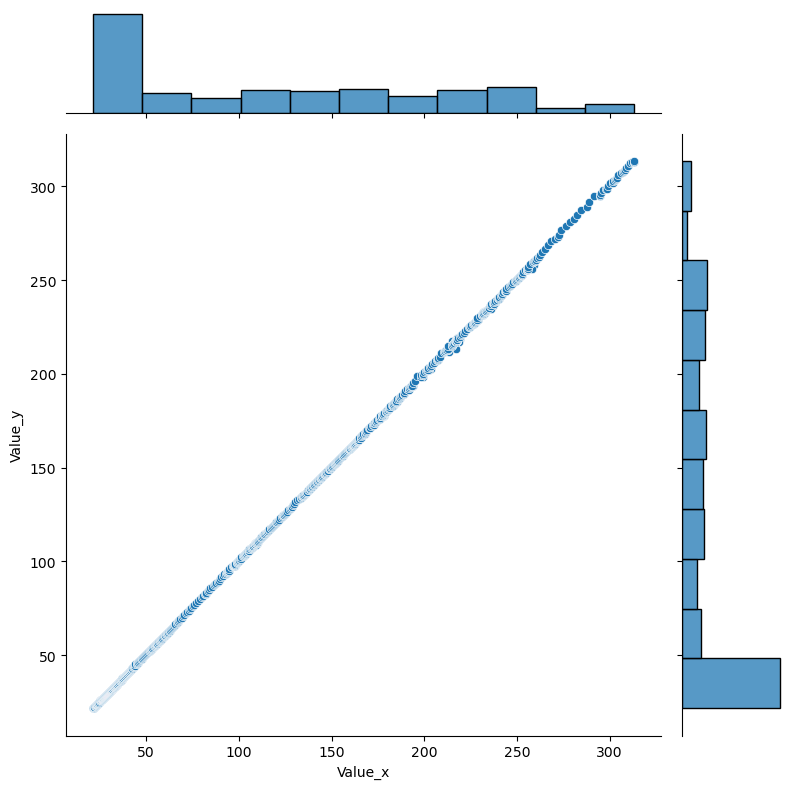

In [976]:
# Visualise the relationship between CPI and Lagged CPI data
sb.jointplot(data=lagged_cpi_cpi, x='Value_x', y='Value_y', height = 8)

#### Preparing train and test datasets
> Total size: 930 values  
> Train set: 744 values  
> Test set: 186 values

In [979]:
# Preparation of train and test datasets
laggedcpi_train, laggedcpi_test, cpi_train, cpi_test = train_test_split(lagged_cpi_cpi[['Value_x']],lagged_cpi_cpi[['Value_y']],test_size=186)

In [981]:

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(laggedcpi_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(laggedcpi_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': LinearRegression(fit_intercept=False), 'regressor__fit_intercept': False}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
Test Set MSE: 0.15041793370649614


In [983]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Access the regressor in the pipeline
regressor = best_model.named_steps['regressor']

# Get intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

In [985]:
print(best_model)
print(regressor)
print(intercept)
print(coefficients)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression(fit_intercept=False))])
LinearRegression(fit_intercept=False)
0.0
[[-3.32259760e-01  1.01752679e+00 -1.25907889e-04  2.73946929e-07]]


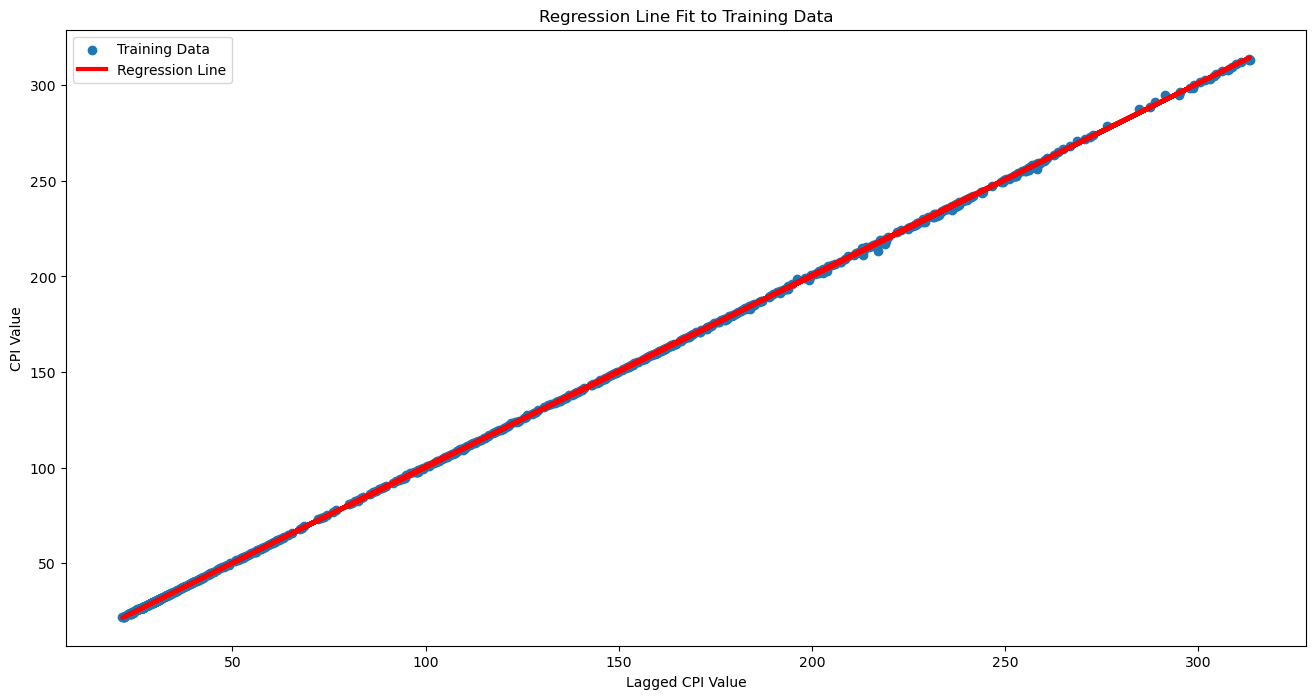

In [987]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract the pipeline steps
poly_transformer = best_model.named_steps['poly']
regressor = best_model.named_steps['regressor']

# Transform neer_train using PolynomialFeatures
laggedcpi_train_transformed = poly_transformer.transform(laggedcpi_train)

# Ensure coefficients are properly shaped for dot product
coefficients = regressor.coef_.ravel()  # Flatten if needed
regline_y = regressor.intercept_ + np.dot(laggedcpi_train_transformed, coefficients)

# Plot scatter plot and regression line
plt.figure(figsize=(16, 8))
plt.scatter(laggedcpi_train, cpi_train, label="Training Data")
plt.plot(laggedcpi_train, regline_y, 'r-', linewidth=3, label="Regression Line")
plt.xlabel("Lagged CPI Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Regression Line Fit to Training Data")
plt.show()

In [989]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Calculate explained variance score
ev_laggedcpi = round(best_model.score(laggedcpi_train, cpi_train), 2)

print("Explained Variance (R^2) for the best model:", ev_laggedcpi)

Explained Variance (R^2) for the best model: 1.0


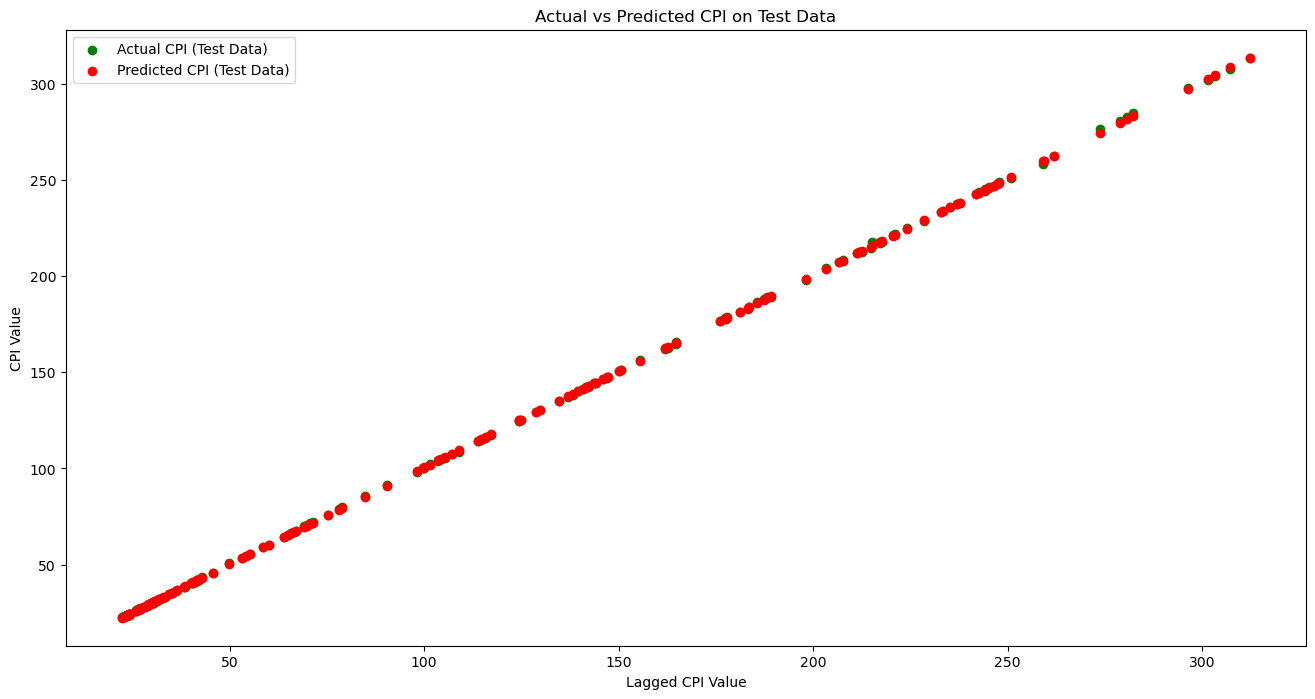

In [991]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict CPI values on the test set
cpi_test_pred = best_model.predict(laggedcpi_test)

# Plot scatter plot for actual vs predicted values
plt.figure(figsize=(16, 8))
plt.scatter(laggedcpi_test, cpi_test, color='green', label="Actual CPI (Test Data)")
plt.scatter(laggedcpi_test, cpi_test_pred, color='red', label="Predicted CPI (Test Data)")
plt.xlabel("Lagged CPI Value")
plt.ylabel("CPI Value")
plt.legend()
plt.title("Actual vs Predicted CPI on Test Data")
plt.show()

In [993]:
# Root Mean Squared Error (RMSE) for comparison
rmse_laggedcpi = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)
rmse_laggedcpi

0.39

### Discussion
After generating a linear regression model to compare each variable against CPI values, we can assess the effectiveness of each variable in predicting CPI values using Explained Variance and Root Mean Square Error (RMSE). 

#### Explained Variance Comparison

Explained variance is used to assess the discrepancy between a model and the actual dataset. Higher percentages of explained variance indicates stronger association between model data and actual data, implying that a model is more accurate in predicting values based on the parameters it has been trained on.

In [997]:
print("Explained Variance on Train Dataset: ")
print("US Unemployment Rate: ", ev_unemp)
print("S&P 500: ", ev_sp)
print("Inflation Expectations: ", ev_bie)
print("Oil Price: ", ev_oil)
print("Producer Price Index (PPI): ", ev_ppi)
print("Nominal Effective Exchange Rate (NEER): ", ev_neer)
print("Lagged CPI: ", ev_laggedcpi)

Explained Variance on Train Dataset: 
US Unemployment Rate:  0.05
S&P 500:  0.92
Inflation Expectations:  0.79
Oil Price:  0.72
Producer Price Index (PPI):  0.99
Nominal Effective Exchange Rate (NEER):  0.37
Lagged CPI:  1.0


Based on the explained variance results above, we can see that  PPI is significantly more effective than the other factors at predicting CPI values in the train set.


#### Root Mean Squared Error Comparison

RMSE is the standard deviation of residuals in the test dataset, representing the distance between actual data points and the model regression line. A lower RMSE value in this context indicates that a factor is more accurate in predicting CPI values.

In [1001]:
# Compare RMSE values for each model

print("RMSE on Test Dataset: ")
print("US Unemployment Rate: ", rmse_unemp)
print("S&P 500: ", rmse_sp)
print("Inflation Expectations: ", rmse_bie)
print("Oil Price: ", rmse_oil)
print("Producer Price Index (PPI): ", rmse_ppi)
print("Nominal Effective Exchange Rate (NEER): ", rmse_neer)
print("Lagged CPI: ", rmse_laggedcpi)

RMSE on Test Dataset: 
US Unemployment Rate:  77.13
S&P 500:  15.66
Inflation Expectations:  11.07
Oil Price:  28.86
Producer Price Index (PPI):  9.98
Nominal Effective Exchange Rate (NEER):  33.07
Lagged CPI:  0.39


Comparing the RMSE values on our models further supports our earlier results from the train dataset. PPI have the lowest RMSE values, indicating that PPI model had the highest accuracy in predicting CPI values in the test set.   

However, despite the relative accuracy of PPI as shown in our results, it must be clarified that we cannot make conclusions about the causal relationship between these factors and CPI. While there seems to be a strong correlation between these factors and CPI values, there are many economic and geopolitical variables that remain as key drivers for an inflationary environment.  
  
We believe the value of our results is in highlighting the fact that in today's highly dynamic global environment, it is imperative to consider emerging trends and their impact on the economy. Governments and financial institutions can benefit from expanding their scope of analysis to gain a more accurate prediction of inflationary pressures.